In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
#matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import pdb
#import ipdb
import h5py
import importlib
import pickle
import math

# Add root folder to sys path
sys.path.append("../")

from load_expert_traj import recursively_save_dict_contents_to_group

# %pylab inline
# inline doesn't give interactive plots
%matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

In [2]:
def draw_circle(centre, w, r, direction=1, T = 120, theta_offset = 0):
    c_x = centre[0]
    c_y = centre[1]
    theta_offset = math.radians(theta_offset)
    
    list_of_points = []
    
    old_x = c_x + r * math.sin(theta_offset)
    old_y = c_y - r * math.cos(theta_offset)
    list_of_points.append((old_x, old_y))
    
    for t in range(1, T):
        theta = math.radians(w * t * direction)
        new_x = c_x + r * math.sin(theta + theta_offset)
        new_y = c_y - r * math.cos(theta + theta_offset)
        
        del_x = new_x - old_x # normalize these to unit vectors to get actions
        del_y = new_y - old_y
        
        old_x = new_x
        old_y = new_y
        list_of_points.append((old_x, old_y))
        
    return list_of_points       

In [3]:
# Meta policy 1

def draw_trajectory_for_policy_1(r1=5, r2=3, r3=3, plot=True):
    centre1 = (0.0, 0.0)
    w1, T1 = 3 ,120
    circle_1 = draw_circle(centre = centre1, w = w1, r = r1, direction=1, T = T1, theta_offset = 0)

    centre2 = (0.0, -8.0)
    w2, T2 = 3, 120
    circle_2 = draw_circle(centre = centre2, w = w2, r = r2, direction=-1, T = T2, theta_offset = 180)

    centre3 = (0.0, -2.0)
    w3, T3 = 3, 120
    circle_3 = draw_circle(centre = centre3, w = w3, r = r3, direction=1, T = T3, theta_offset = 0)

    x_list = []
    y_list = []
    for i in range(len(circle_1)):
        x_list.append(circle_1[i][0])
        y_list.append(circle_1[i][1])
    for i in range(len(circle_2)):
        x_list.append(circle_2[i][0])
        y_list.append(circle_2[i][1])
    for i in range(len(circle_3)):
        x_list.append(circle_3[i][0])
        y_list.append(circle_3[i][1])
    
    if plot:
        colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
        plt.scatter(x_list, y_list, color=colors) 
        plt.axis('equal')    
        plt.title("Policy 1: R1: {:.2f}, R2: {:2f}, R3: {:.3f}".format(r1, r2, r3))
        plt.show()
    return x_list, y_list

In [4]:
# Meta policy 2
def draw_trajectory_for_policy_2(r1=5, r2=3, r3=3, plot=True):

    centre1 = (0.0, 0.0)
    w1, T1 = 3, 120
    circle_1 = draw_circle(centre = centre1, w = w1, r = r1, direction=1, T = T1, theta_offset = 0)

    centre2 = (0.0, -2.0)
    w2, T2 = 3, 120
    circle_2 = draw_circle(centre = centre2, w = w2, r = r2, direction=1, T = T2, theta_offset = 0)

    centre3 = (0.0, -8.0)
    w3, T3 = 3, 120
    circle_3 = draw_circle(centre = centre3, w = w3, r = r3, direction=-1, T = T3, theta_offset = 180)


    x_list, y_list = [], []
    for i in range(len(circle_1)):
        x_list.append(circle_1[i][0])
        y_list.append(circle_1[i][1])
    for i in range(len(circle_2)):
        x_list.append(circle_2[i][0])
        y_list.append(circle_2[i][1])
    for i in range(len(circle_3)):
        x_list.append(circle_3[i][0])
        y_list.append(circle_3[i][1])
    
    if plot:
        colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
        plt.scatter(x_list, y_list, color=colors) 
        plt.axis('equal')    
        plt.title("Policy 2: R1: {:.2f}, R2: {:2f}, R3: {:.3f}".format(r1, r2, r3))
        plt.show()
    return x_list, y_list

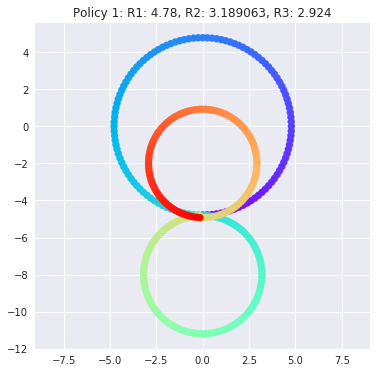

> <ipython-input-5-b5963a7db924>(34)<module>()
-> states, actions = get_state_action_from_positions(states_x, states_y)
(Pdb) type(states_x)
<type 'list'>
(Pdb) len(states_x)
360
(Pdb) len(states_y)
360
(Pdb) states_x[119]
-0.25032941295252154
(Pdb) states_x[12]
2.811450247808573
(Pdb) states_x[120]
3.9054756243334717e-16
(Pdb) q


BdbQuit: 

In [5]:
def get_state_action_from_positions(pos_x_list, pos_y_list):
    # states are (x, y) actions are (delta_x, delta_y)
    states, actions = [], []
    for i in range(len(pos_x_list)):
        states.append((pos_x_list[i], pos_y_list[i]))
    for i in range(1, len(states)):
        a = (states[i][0] - states[i-1][0], states[i][1] - states[i-1][1])
        actions.append(a)
    # Remove the last state
    return states[:-1], actions

def save_expert_traj_dict_to_h5(traj_data_dict, save_dir,
                               h5_filename='expert_traj.h5'):
     h5_f = h5py.File(os.path.join(save_dir, h5_filename), 'w')
     recursively_save_dict_contents_to_group(h5_f, '/', traj_data_dict)
     h5_f.flush()
     h5_f.close()
     print("Did save data to {}".format(os.path.join(save_dir, h5_filename)))

# Get trajectories for policy 1 (10 trajectories)
num_traj = 20
r1 = np.random.normal(5, 0.2, num_traj)
r2 = np.random.normal(3, 0.1, num_traj)
r3 = np.random.normal(3, 0.1, num_traj)

env_data_dict = {'num_goals': 2, 'num_actions': 1}
expert_data_dict = {}
for i in range(num_traj):
    r1_idx, r2_idx = np.random.randint(num_traj), np.random.randint(num_traj)
    r3_idx = np.random.randint(num_traj)
    states_x, states_y = draw_trajectory_for_policy_1(
        r1=r1[r1_idx], r2=r2[r2_idx], r3=r3[r3_idx], plot=True)
    pdb.set_trace()
    states, actions = get_state_action_from_positions(states_x, states_y)
    key = 'p1_{:.2f}_{:.2f}_{:.2f}'.format(r1[r1_idx], r2[r2_idx], r3[r3_idx])
    expert_data_dict[key] = {}
    expert_data_dict[key]['state'] = np.array(states)
    expert_data_dict[key]['action'] = np.array(actions)
    expert_data_dict[key]['goal'] = np.ones(len(states)) * 0

# generate trajectories for policy 2
for i in range(num_traj):
    r1_idx, r2_idx = np.random.randint(num_traj), np.random.randint(num_traj)
    r3_idx = np.random.randint(num_traj)
    states_x, states_y = draw_trajectory_for_policy_2(
        r1=r1[r1_idx], r2=r2[r2_idx], r3=r3[r3_idx], plot=True)
    pdb.set_trace()
    states, actions = get_state_action_from_positions(states_x, states_y)
    key = 'p2_{:.2f}_{:.2f}_{:.2f}'.format(r1[r1_idx], r2[r2_idx], r3[r3_idx])
    expert_data_dict[key] = {}
    expert_data_dict[key]['state'] = np.array(states)
    expert_data_dict[key]['action'] = np.array(actions)
    expert_data_dict[key]['goal'] = np.ones(len(states)) * 1

data_to_save = {
    'expert_traj': expert_data_dict,
    'obstacles': np.array([]),
    'set_diff': np.array([]),
    'env_data': env_data_dict,
}

SAVE_DATA = False
if SAVE_DATA:
    import os
    save_dir = '../h5_trajs/circle_trajs/meta_2_traj_40'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_expert_traj_dict_to_h5(data_to_save, save_dir)